In [1]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import skimage
from skimage.io import imread
from skimage.transform import resize

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
train_data = []
for filename in os.listdir('Data/train'):
    # load image
    img_data = PIL.Image.open('Data/train/' + filename)
    # store loaded image
    train_data.append(np.asarray(img_data))
train_data=np.asarray(train_data)
# train_data=train_data/255
# train_data = np.reshape(train_data, (len(train_data), 272, 256, 1))

In [5]:
train_data = []
for filename in os.listdir('Data/train'):
    img = imread('Data/train/'+filename)
    img = np.expand_dims(img,axis=-1)
    img = np.asarray(img)
    train_data.append(img)
train_data=np.asarray(train_data)
train_data=train_data/255

In [6]:
x=np.isnan(train_data)
x.sum()

51352

In [7]:
train_data[x]=0

In [8]:
x=np.isnan(train_data)
x.sum()

0

In [9]:
valid_data = []
for filename in os.listdir('Data/valid'):
    img = imread('Data/valid/'+filename)
    img = np.expand_dims(img,axis=-1)
    img = np.asarray(img)
    valid_data.append(img)
valid_data=np.asarray(valid_data)
valid_data=valid_data/255

In [10]:
inputs = Input(shape=(256, 272, 1), name="inputs")
x = inputs

In [11]:
x = Conv2D(8, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(16, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
# x = MaxPool2D((2,2))(x)

skip_x = x

x = Conv2D(16, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.add([x, skip_x])
x = MaxPool2D((2,2))(x)

# skip_x = MaxPool2D((3,3))(skip_x) 

x = Conv2D(32, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
# x = MaxPool2D((2,2))(x)

skip_x1 = x

x = Conv2D(32, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.add([x, skip_x1])
x = MaxPool2D((2,2))(x)

x = Conv2D(32, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(16, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(8, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
# x = tf.keras.layers.add([x, skip_x1])
# x = MaxPool2D((2,2))(x)


In [12]:
latent = Flatten()(x)

In [13]:
x = Reshape((16,17,8))(latent)
x = Conv2DTranspose(8, (5, 5),strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(16, (5, 5),strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(32, (5, 5),strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(16,(5, 5), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(8,(5, 5), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(1,(5, 5), strides=2, padding="same")(x)
x = BatchNormalization()(x)
# x = LeakyReLU(alpha=0.2)(x)
x = Activation("relu", name="outputs")(x)

outputs = x

In [14]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss=tf.keras.losses.MeanAbsoluteError())
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 256, 272, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 272, 8)  208         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 272, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 272, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
checkpoint_path = "Checkpoints/CAE/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 2 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=2)

In [16]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [18]:
history = autoencoder.fit(
    train_data,train_data,epochs=50,
    batch_size=32,
    shuffle=False,
    validation_data=(valid_data,valid_data),
    steps_per_epoch=len(train_data) // 32,callbacks=[cp_callback,reduce_lr]
)

Epoch 1/50
50/50 [==============================] - 13s 253ms/step - loss: 0.1279 - val_loss: 0.3787 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.0723
Epoch 00002: saving model to Checkpoints/CAE/cp-0002.ckpt
50/50 [==============================] - 12s 247ms/step - loss: 0.0723 - val_loss: 0.0585 - lr: 9.5000e-04
Epoch 3/50
50/50 [==============================] - 12s 232ms/step - loss: 0.0598 - val_loss: 0.0575 - lr: 9.0250e-04
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.0552
Epoch 00004: saving model to Checkpoints/CAE/cp-0004.ckpt
50/50 [==============================] - 12s 246ms/step - loss: 0.0552 - val_loss: 0.0642 - lr: 8.5737e-04
Epoch 5/50
50/50 [==============================] - 12s 234ms/step - loss: 0.0525 - val_loss: 0.0620 - lr: 8.1451e-04
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.0503
Epoch 00006: saving model to Checkpoints/CAE/cp-0006.ckpt
50/50 [==============================

Epoch 47/50
50/50 [==============================] - 12s 237ms/step - loss: 0.0284 - val_loss: 0.0313 - lr: 9.4468e-05
Epoch 48/50
50/50 [==============================] - ETA: 0s - loss: 0.0281
Epoch 00048: saving model to Checkpoints/CAE/cp-0048.ckpt
50/50 [==============================] - 12s 246ms/step - loss: 0.0281 - val_loss: 0.0322 - lr: 8.9745e-05
Epoch 49/50
50/50 [==============================] - 12s 234ms/step - loss: 0.0282 - val_loss: 0.0329 - lr: 8.5258e-05
Epoch 50/50
50/50 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00050: saving model to Checkpoints/CAE/cp-0050.ckpt
50/50 [==============================] - 12s 243ms/step - loss: 0.0284 - val_loss: 0.0332 - lr: 8.0995e-05


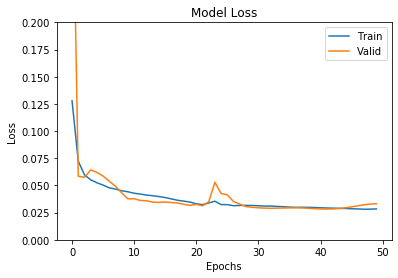

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.20)
plt.legend(['Train', 'Valid'])
plt.show()
# plt.savefig('loss.png')

In [22]:
decoded_imgs = autoencoder.predict(valid_data)

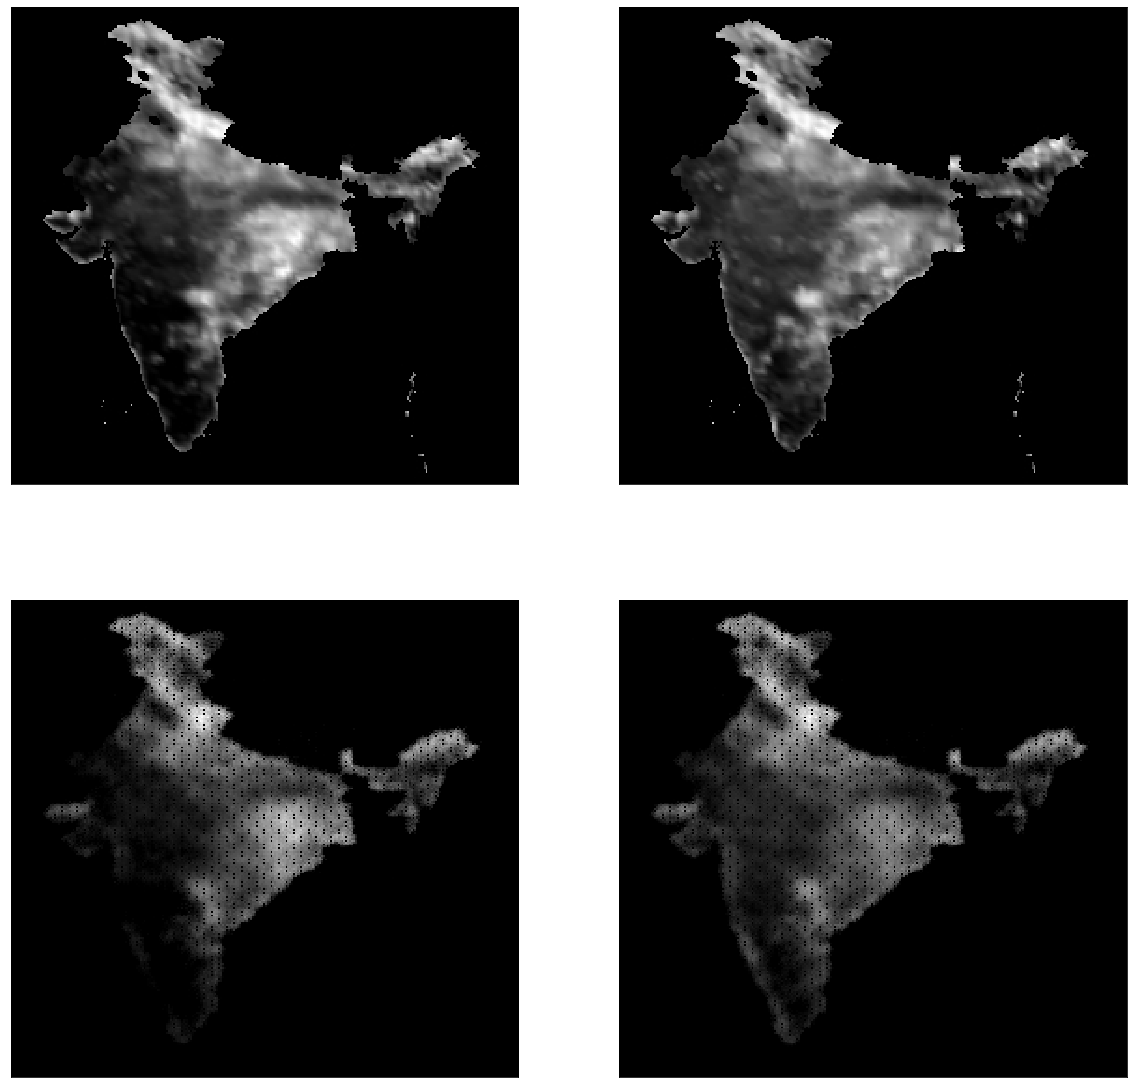

In [29]:
n = 2
plt.figure(figsize=(20,20))
for i in range(n):
    # display original
    ax = plt.subplot(n ,2, i + 1)
    plt.imshow(valid_data[i].reshape(256, 272),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n ,2, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 272),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()